<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Demonstration of ML Training using Apache Spark MLlib </h1></div>
<div style="text-align:center"><h2><i>Random forest and Gradient-boosted trees</i></h2></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

This notebook demonstrates ML using Apache Spark MLlib and has been developed in the context on Hadoop and Spark service at CERN  
***Author: Matteo Migliorini***_  
***Contact: Matteo Migliorini / Luca Canali / Prasanth Kothuri***  
  
To run this notebook we used the following configuration:
* *Software stack*: Developing bleeding edge (it has spark 2.3.1)
* *Platform*: centos7-gcct
* *Number of cores*: 4
* *Memory*: 10G
* *Spark cluster*: Analytix

Let's test if the spark session has been created correctly.

In [1]:
spark

## Table of contents

* [Dataset description](#description)
* [Load the dataset](#load)
* [Feature preparation](#preparation)
* [Random Forest](#rf)
    * [Grid Search](#gridSearch)
* [Gradient-Boosting Trees](#gbt)

<a id=description></a><br>

## Dataset description

The dataset used in this example is the same used in [this paper](https://arxiv.org/pdf/1402.4735.pdf) and it has been produced using Monte Carlo simulations. It is a binary classificatin problem where the goal is to train a classifier able to distinguish between a *signal* process, the production of new theoretical Higgs bosons, and a *background* process with identical decay products but distinct kinematic features. <br>

Each row of this dataset contains 28 features plus the label:
* 21 *low-level features* which represent the basic measure made by the particle detector
    * Momentum of the observed paricles
    * Missing transverse momentum 
    * Jets and b-tagging information
* 7 *high-level features* computed from the low-level features that encode the knowledge of the different intermediate states of the two processes
    * Reconstructed invariant mass of the 

The dataset can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/HIGGS) (This version doesn't have the header) or found here `hdfs://analytix/user/migliori/benchmarkData/Higgs10M.csv` .  

<a id=load></a><br>

## Load the dataset

As firts step we will load the sample insto a Spark dataframe infering the schema

In [3]:
from __future__ import print_function

In [2]:
df = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferschema', 'true')\
    .load('hdfs://analytix/project/spark/examples/MLHiggs/Higgs10M.csv')

total_events = df.count()
print('There are',total_events,'events')

('There are', 10000000, 'events')


In [4]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

We can count how many events there are foreach class to see if the dataset is unbalanced

In [5]:
df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|  0.0|4700495|
|  1.0|5299505|
+-----+-------+



As we can see the dataset seems to be balanced, hence we can split it into `train` and `test` dataframes.<br>
The fraction of  events used for the training stage is $0.98$ and the remainig $0.02$ will be used to test our classifier. In this way we will have approximately $200$k events for the testing phase.

In [6]:
train, test = df.randomSplit([0.98,0.02])

In [7]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 9799800
Events for the validation 200200


<a id=visualization></a><br>

## Data visualization

We can plot some features to see how data are distributed with respect the two classes

In [8]:
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col
%matplotlib notebook

def compute_hist(data, feature, target='label', n_bins=100, x_lim=[0,3]):
        
    ## Fix the range
    data = data.where((col(feature)<=x_lim[1]) &
                      (col(feature)>=x_lim[0]))
    
    sgn = data.where(col(target)==1.0) 
    bkg = data.where(col(target)==0.0)

    ## Compute the histograms
    bins_sgn, counts_sgn = sgn.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    bins_bkg, counts_bkg = bkg.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    
    return (bins_sgn, counts_sgn), (bins_bkg, counts_bkg)

<IPython.core.display.Javascript object>


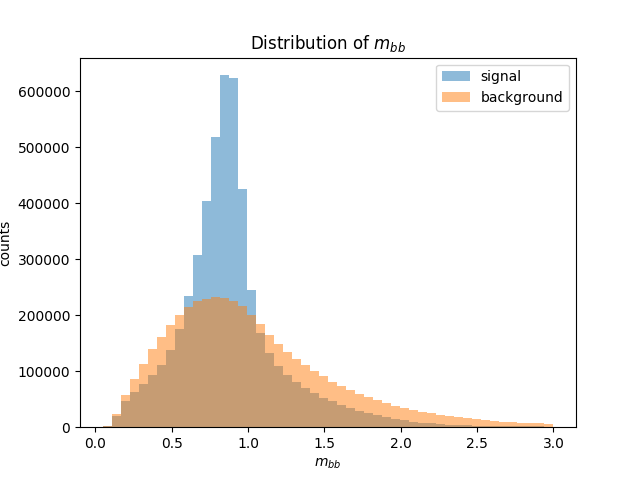

In [10]:
%matplotlib notebook

## hist is a touple containing bins and counts foreach bin
hist_signal, hist_bkg = compute_hist(data=train, feature='m_bb', target='label', n_bins=50, x_lim=[0,3])

f, ax = plt.subplots()
ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1], alpha=0.5, label='signal')
ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1], alpha=0.5, label='background')
ax.set_xlabel('$m_{bb}$')
ax.set_ylabel('counts')
ax.set_title("Distribution of $m_{bb}$")
ax.legend()
plt.show()

<a id=preparation></a><br>

## Feature preparation

In this section we will prepare the input for the classifier. <br>
For the random forest we don't need to scale the features and encode the labels, we need only to create a `Dense Vector` containing the features.

In [11]:
feature = train.columns
feature.remove('label')
feature

['lepton_pT',
 'lepton_eta',
 'lepton_phi',
 'missing_energy_magnitude',
 'missing_energy_phi',
 'jet1_pt',
 'jet1_eta',
 'jet1_phi',
 'jet1_b-tag',
 'jet2_pt',
 'jet2_eta',
 'jet2_phi',
 'jet2_b-tag',
 'jet3_pt',
 'jet3_eta',
 'jet3_phi',
 'jet3_b-tag',
 'jet4_pt',
 'je4_eta',
 'jet4_phi',
 'jet4_b-tag',
 'm_jj',
 'm_jjj',
 'm_lv',
 'm_jlv',
 'm_bb',
 'm_wbb',
 'm_wwbb']

To create a vector containing all the features we can use the `VectorAssembler`: we need to instantiate it specifying the column containing the features and the output column that will contain the assembled vector. After this we can *transform* (create the assembled vectors) the tain and test dataframe.

In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

This is how a single row of the features column looks like

In [14]:
train.select('features').take(1)

[Row(features=DenseVector([0.2747, -1.984, 0.7695, 1.4013, 1.496, 0.9565, 0.3327, -0.0321, 0.0, 0.7049, -0.8722, -1.0061, 2.2149, 0.6468, -0.353, -0.6304, 0.0, 1.0686, -0.2303, 1.3877, 3.102, 0.8953, 0.9776, 0.9931, 0.7897, 0.6978, 0.7528, 0.7791]))]

We can now plot the correlation matrix for the features 

In [15]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(train.select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

<IPython.core.display.Javascript object>


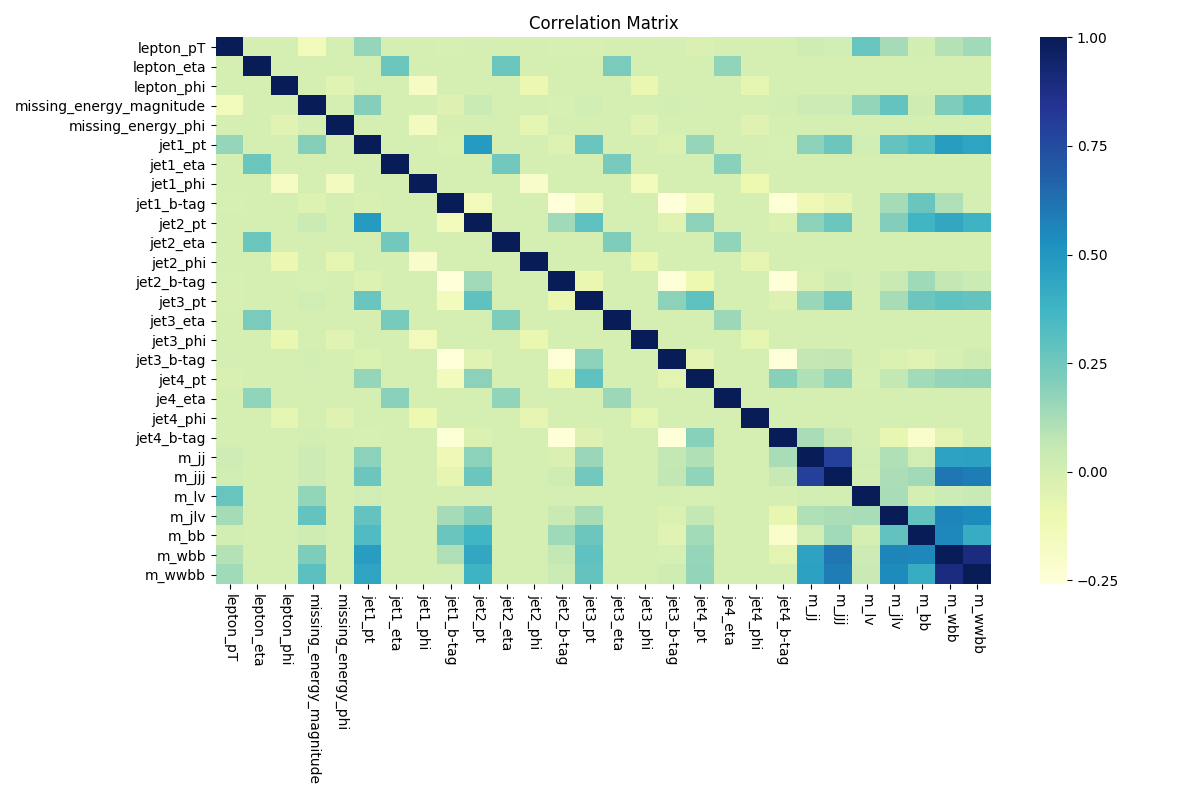

In [24]:
import seaborn as sns

matrix_np = matrix_np.reshape(len(feature),len(feature))

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix_np, cmap="YlGnBu")
ax.xaxis.set_ticklabels(feature, rotation=270)
ax.yaxis.set_ticklabels(feature, rotation=0)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

<a id=rf></a><br>

## Random Forest

**Random forest** are *ensemble learning* methos for classification and regression problems. In a Random forest we are combining  a large number of independent trees trained over random and equally distributed subsets of the data obtained by sampling with replacement the original dataset. More infos about random forest [here](#https://en.wikipedia.org/wiki/Random_forest).

As a starting point we will train a simple random forest with $50$ trees, without tuning the hyperparameters. We need to specify the columns containing the features vector and the label.

In [25]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50)

In [26]:
rf = rf.fit(train)

We can now use our trained model to predict the test instances

In [27]:
pred = rf.transform(test)

In [28]:
pred.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.61620582497646...|
|  0.0|       1.0|[0.45361806258826...|
|  0.0|       1.0|[0.49516458841220...|
|  0.0|       0.0|[0.51070779550800...|
|  0.0|       0.0|[0.52628372242881...|
+-----+----------+--------------------+
only showing top 5 rows



Since the test dataset is small we can convert it into a pandas dataframe. This allows us to use `sklearn` and `matplotlib`.

In [29]:
pred_pd = pred.select(['label', 'prediction', 'probability']).toPandas()

In [30]:
pred_pd.head()

,label,prediction,probability
0,0.0,0.0,"[0.616205824976467, 0.3837941750235329]"
1,0.0,1.0,"[0.45361806258826753, 0.5463819374117326]"
2,0.0,1.0,"[0.49516458841220823, 0.5048354115877918]"
3,0.0,0.0,"[0.5107077955080056, 0.4892922044919945]"
4,0.0,0.0,"[0.5262837224288193, 0.4737162775711807]"


We need to convert the column `prediction` into a list, because now it is of type `VectorDense`. We will create a new column `encoded_label` that we will use to plot the `roc curve`.

In [31]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [32]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [33]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 0.749


<IPython.core.display.Javascript object>


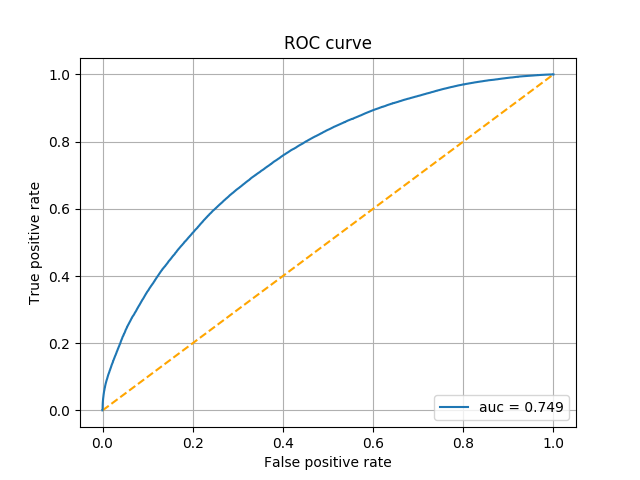

In [34]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<a id=gridSearch></a><br>
### Grid Search

We can try to improve the performance of the classifier by tuning the hyperparameter such as the number of trees in the forest and the depth of each tree. <br>

First of all we will create a smaller sample of $\sim 80k$ for the grid search and cache it, because we will use it for different iterations.

In [35]:
subSample = train.sample(fraction=1.0/120, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')

We will use 81493  events for the grid search.


In this example we will perform a small grid search: in a real case a larger grid and more folds for the cross-validation should be used. We will now perform a search on a small grid, ideally you want to test more parameters and use more folds for the cross-validation.

In [36]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            maxBins=20, subsamplingRate=0.7,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [10,20])\
  .addGrid(rf.numTrees, [50])\
  .build()

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=2)

In [37]:
bestModel = cv.fit(subSample)

It is possile to see the score obtained (in this case the AUC) for each set of parameters

In [38]:
zip(bestModel.avgMetrics, paramGrid)

[(0.7805406505739716,
  {Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
   Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='numTrees', doc='Number of trees to train (>= 1).'): 50}),
 (0.780174188868053,
  {Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 20,
   Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='numTrees', doc='Number of trees to train (>= 1).'): 50})]

We can get the parameter we are interested in and use them to train a random forest on the full dataset

In [39]:
print('BestModel:\n\t-maxDepth =',bestModel.bestModel._java_obj.getMaxDepth())
print('\t-numTrees =',bestModel.bestModel._java_obj.getNumTrees())

BestModel:
	-maxDepth = 10
	-numTrees = 50


We can also get the list off all the parameters (including the default values) using `extractParamMap()`

In [40]:
bestModel.bestModel.extractParamMap()

{Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='seed', doc='random seed'): -4140900678877021401,
 Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='numTrees', doc='Number of trees to train (>= 1)'): 50,
 Param(parent=u'RandomForestClassifier_48beaadf31caf56c3373', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree,

A benefit of using ensemble methods (like Random Forest and Gradient Boosting) is that it is really easy to extract the importance scores of each attribute. As the name suggests, the importance of a feature indicates how usefull a feature was during the construction of the trees. The more an attribute is used to make decision within a tree, the higher its importance is.

<IPython.core.display.Javascript object>


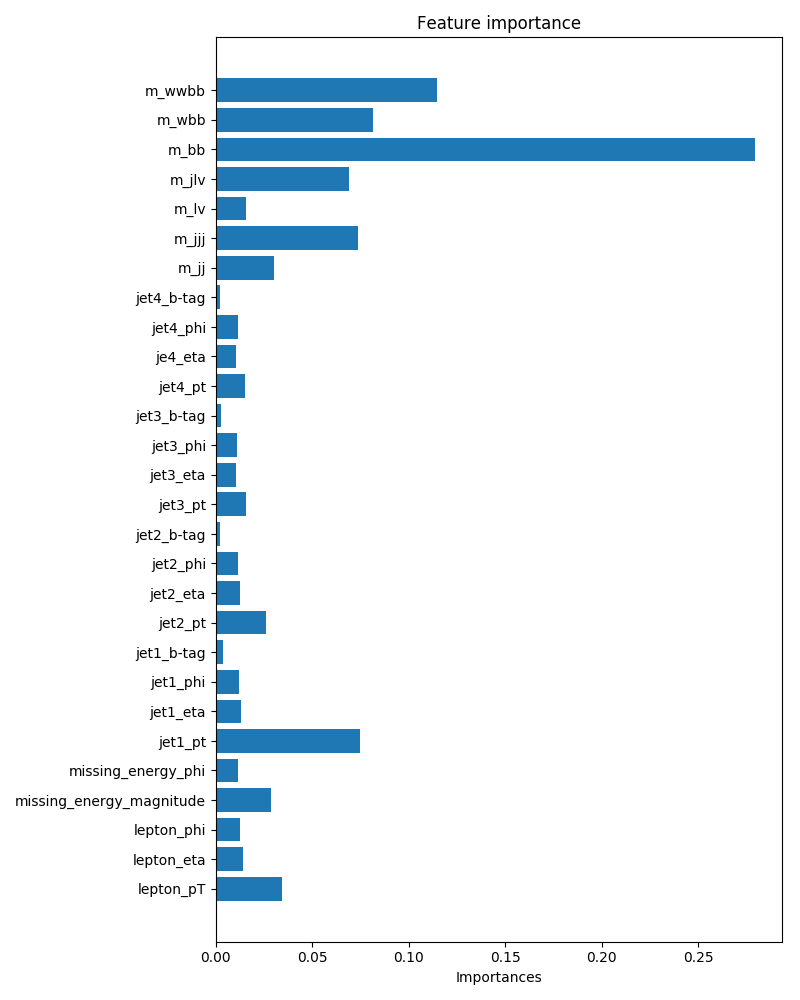

In [41]:
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(range(28), bestModel.bestModel.featureImportances.toArray())
ax.set_yticks(range(28))
ax.set_yticklabels(feature)
ax.set_xlabel('Importances')
ax.set_title('Feature importance')
plt.tight_layout()
plt.show()

As one would expect the most important features are the *high-level* ones (because we are putting information inside them) and momentum of lepton, missing energy and leading jet. <br>
We can now remove the `subSample` dataframe and train the model on the full dataset.

In [42]:
subSample = subSample.unpersist()
del subSample

In [43]:
important_features = ['lepton_pT', 'missing_energy_magnitude',
                      'jet1_pt', 'jet2_pt',
                      'm_jlv', 'm_jj', 'm_jjj',
                      'm_bb', 'm_wbb', 'm_wwbb']

In [44]:
assembler = VectorAssembler(inputCols=important_features, outputCol='important_features')
train = assembler.transform(train)
test = assembler.transform(test)

In [45]:
rf_all = RandomForestClassifier(labelCol='label', featuresCol='important_features', 
                            numTrees=100, maxDepth=15,
                            maxBins=20, subsamplingRate=0.6,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

In [46]:
%%time
model = rf_all.fit(train)

CPU times: user 12.6 s, sys: 4.62 s, total: 17.3 s
Wall time: 29min 11s


We can now save the model. It will be saved as a **parquet** file

In [33]:
model.write().overwrite().save(path='hdfs://analytix/user/migliori/benchmarkData/rf_model')

and it is possible to reload it in the following way

In [14]:
from pyspark.ml.classification import RandomForestClassificationModel
loaded_rf = RandomForestClassificationModel\
        .load('hdfs://analytix/user/migliori/benchmarkData/rf_model')

In [20]:
pred_full = loaded_rf.transform(test)

In [21]:
pred_pd_full = pred_full.select(['label', 'prediction', 'probability']).toPandas()

In [24]:
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_label'] = pred_pd_full['label'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_label'].tolist())

<IPython.core.display.Javascript object>


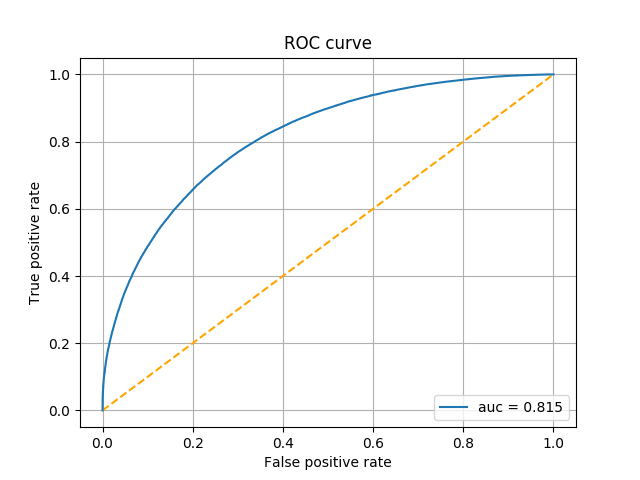

In [25]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<b>This result is consistent with the results obtained in the paper when using a BDT and a Shallow NN with all the features ($
AUC\approx0.81$). We managed to obtain the same result using only the important feature found with the cross-validation. </b><br>

We can now plot the predicted signal and background 

In [ ]:
hist_signal_pred, hist_bkg_pred = compute_hist(data=pred_full,
                                               feature='m_bb', target='prediction',
                                               n_bins=50, x_lim=[0,3])

hist_signal_pred, hist_bkg_pred = compute_hist(data=pred_full,
                                               feature='m_bb', target='prediction',
                                               n_bins=50, x_lim=[0,3])

<IPython.core.display.Javascript object>


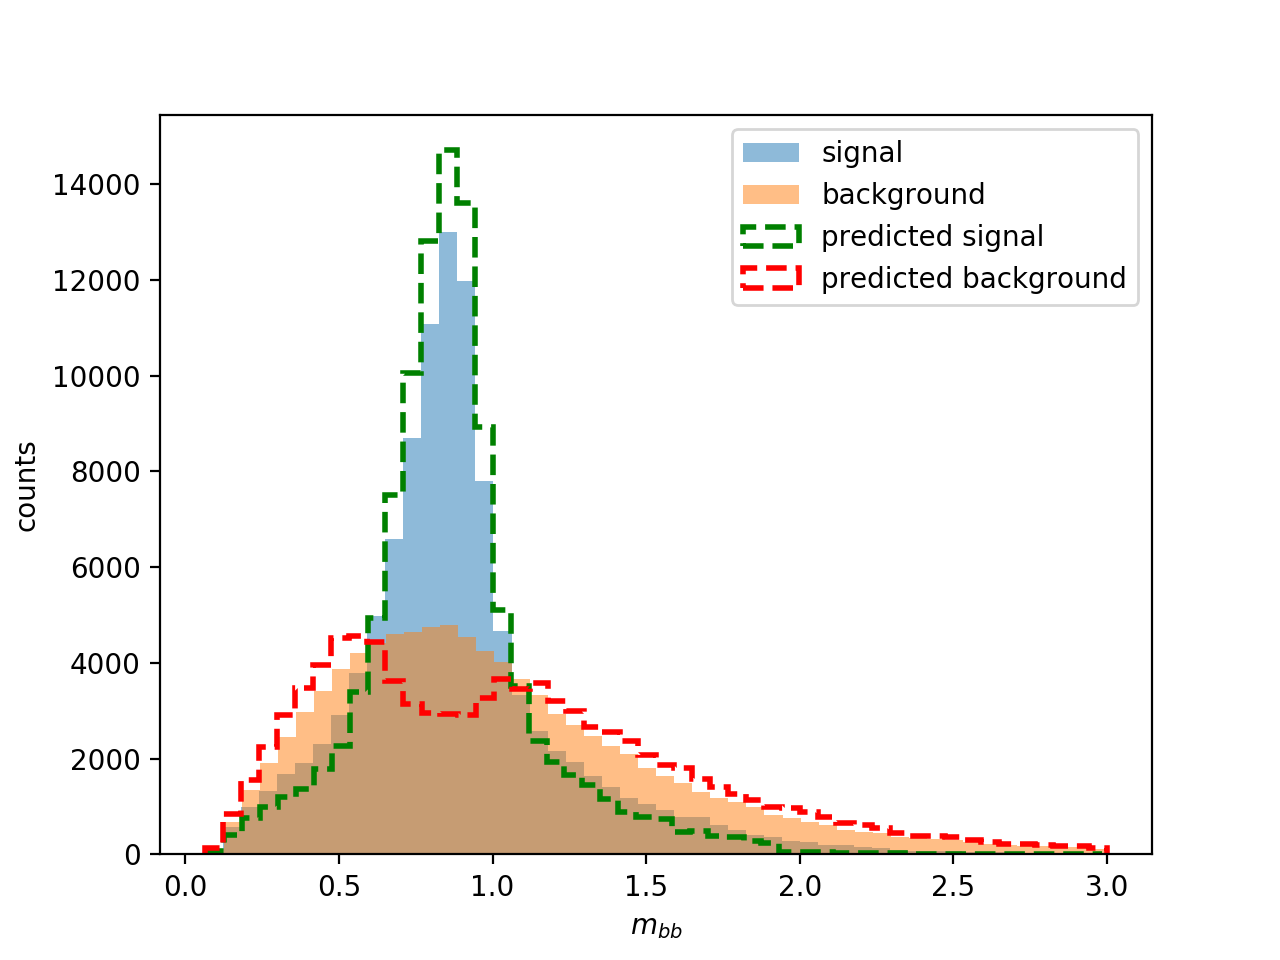

In [41]:
%matplotlib notebook

f, ax = plt.subplots()
ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1],
        alpha=0.5, label='signal')
ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1],
        alpha=0.5, label='background')

ax.hist(hist_signal_pred[0][:-1], bins=hist_signal_pred[0], weights=hist_signal_pred[1],
        label='predicted signal', histtype='step',
        linestyle='--', color='green', linewidth=2)
ax.hist(hist_bkg_pred[0][:-1], bins=hist_bkg_pred[0], weights=hist_bkg_pred[1],
        label='predicted background', histtype='step',
        linestyle='--', color='red', linewidth=2)

ax.set_xlabel('$m_{bb}$')
ax.set_ylabel('counts')
ax.legend()
ax.set_title("Distribution of $m_{bb}$")
plt.show()

<a id=gbt></a><br>
## Gradient-Boosting Trees

Like Random Forest, Gradient Boosting Trees is a machine learning technique which produces a prediction model in the form of an ensemble of of weak prediction trees. Unlike random forest, GBT optimize a cost function over a function space by iteratively choosing a function that points in the negative gradient direction. More about GBT [here](#https://en.wikipedia.org/wiki/Gradient_boosting).

The pipeline in spark is the same of the random forest, it is sufficient to substitute `RandomForestClassifier` with `GBTClassifier`.   

In [50]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10)

In [51]:
%%time
gbt_model = gbt.fit(train)

CPU times: user 2min 21s, sys: 1min 44s, total: 4min 6s
Wall time: 19min 20s


In [53]:
pred_gbt = gbt_model.transform(test)

In [54]:
pred_pd_gbt = pred_gbt.select(['label', 'prediction', 'probability']).toPandas()

In [55]:
pred_pd_gbt['probability'] = pred_pd_gbt['probability'].map(lambda x: list(x))
pred_pd_gbt['encoded_label'] = pred_pd_gbt['label'].map(lambda x: np.eye(2)[int(x)])

y_pred_gbt = np.array(pred_pd_gbt['probability'].tolist())
y_true_gbt = np.array(pred_pd_gbt['encoded_label'].tolist())

<IPython.core.display.Javascript object>


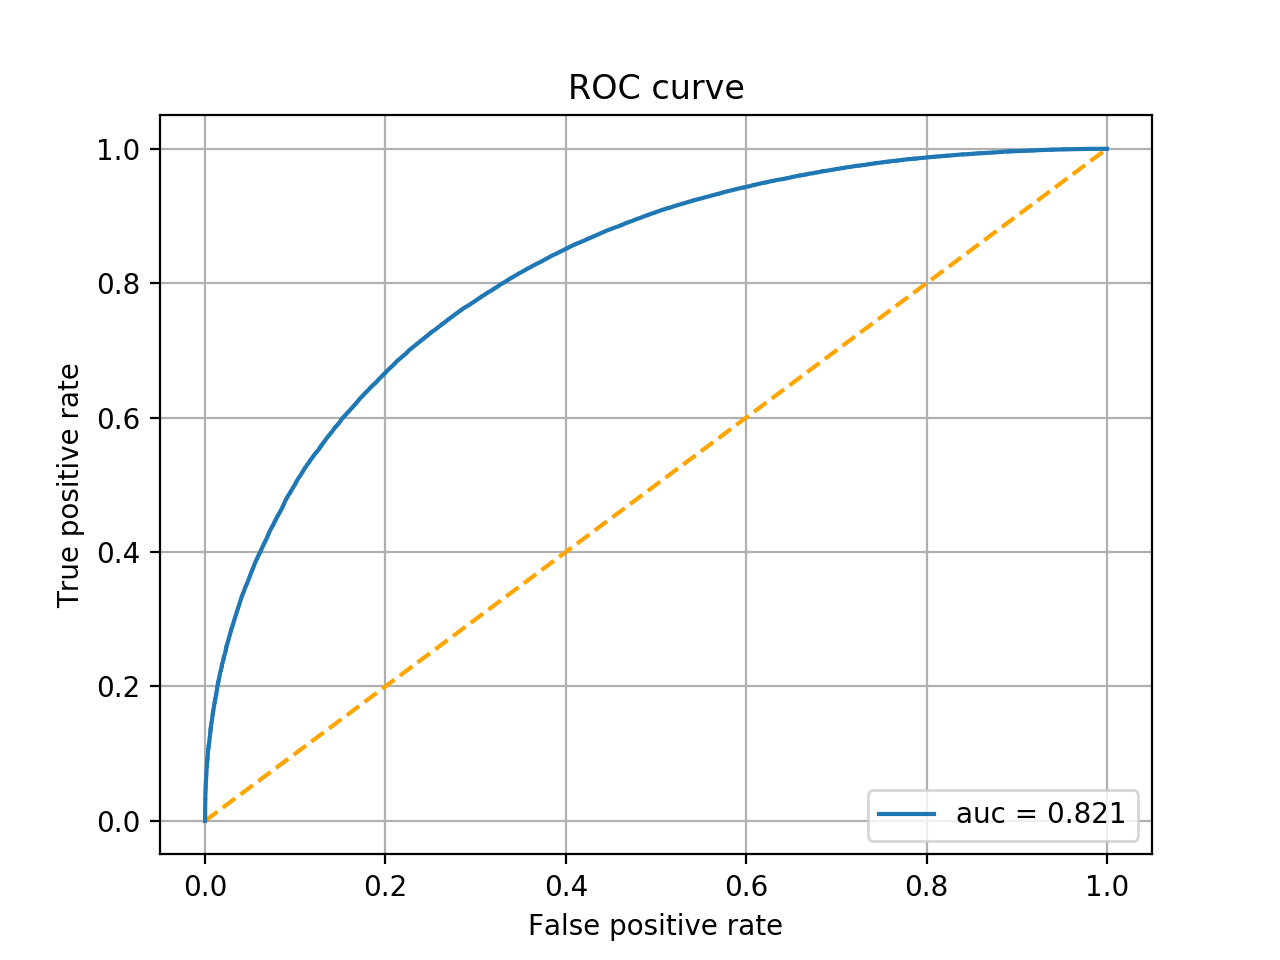

In [57]:
from sklearn.metrics import auc, roc_curve
fpr_gbt, tpr_gbt, threshold_gbt = roc_curve(y_score=y_pred_gbt[:,0], y_true=y_true_gbt[:,0])
auc_gbt = auc(fpr_gbt, tpr_gbt)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_gbt, tpr_gbt, label='auc = {:.3f}'.format(auc_gbt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()